In [17]:
# Chargement des fichiers audios du dossier fan/test dans un dataframe
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa as lb
import seaborn as sns
from os import listdir
from os.path import isfile, join

class File_charge:
    """
    La classe File_charge permet d'instancier un objet de type dataframe contenant les chemins d'accès des fichiers audio
    contenus dans chaque sous dossier du dataset
    
    Paramètres: path : Chemin d'accès au répetoire des fichiers audio
                expemple : path = "C:/Users/romua/Documents/Formation_data_scientist/ASD/dataset/fan/train/"    
    """
    def __init__(self, path):
        self.path = path 
        
    def load_file(self):
        """
        La fonction load_file retourne un dataframe constituer des chemins d'accès aux fichiers audio contenu 
        dans un sous dossier du dataset
        
        """
        
        dirs = os.listdir(self.path)

        df = list()
        for dir in dirs:
            df.append((self.path+"/"+dir))

        df = pd.DataFrame(df, columns = ['audio_file'])
        df = df.reset_index()
        return  df
    
# Fonction de chargement des fichiers audio
def load_audio(audio_path):
    return lb.load(audio_path, sr=None)

# Chargement du dataframe des chemins d'accès des audios contenus dans le dataset/train
"""
Spécifier les chemins d'accès des dossiers contenant les extraits audio
"""

df_slider_train = File_charge("C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/slider/train/")
df_slider_train = df_slider_train.load_file()

df_slider_test = File_charge("C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/slider/test/")
df_slider_test = df_slider_test.load_file()

df_ToyCar_train = File_charge("C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/ToyCar/train/")
df_ToyCar_train = df_ToyCar_train.load_file()

df_ToyCar_test = File_charge("C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/ToyCar/test/")
df_ToyCar_test = df_ToyCar_test.load_file()

# Création d'un tableau des listes des amplitudes des échantillons audio d'entrainement de la machine "fan"
sliders = list()
for i in range(len(df_slider_train)):
    sliders.append(load_audio(df_slider_train.iloc[i,1])[0])

toycars = list()
for i in range(len(df_ToyCar_train)):
    toycars.append(load_audio(df_ToyCar_train.iloc[i,1])[0])   
        
sliders_a=list()
for i in range(len(df_slider_test)):
    if 'anomaly' in df_slider_test['audio_file'][i]:
        sliders_a.append(load_audio(df_slider_test.iloc[i, 1])[0])
        
toycars_a=list()
for i in range(len(df_ToyCar_test)):
    if 'anomaly' in df_ToyCar_test['audio_file'][i]:
        toycars_a.append(load_audio(df_ToyCar_test.iloc[i, 1])[0])


In [30]:
np.shape(sliders_a)

(890, 160000)

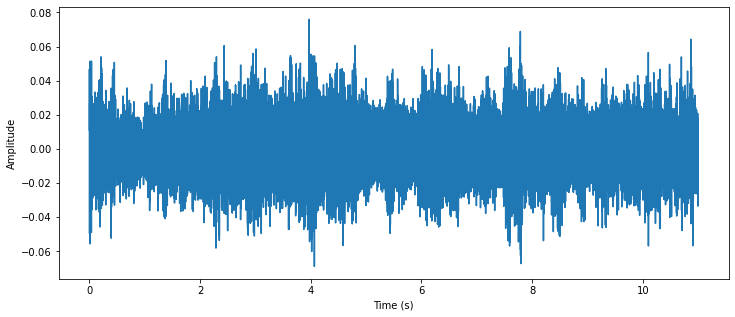

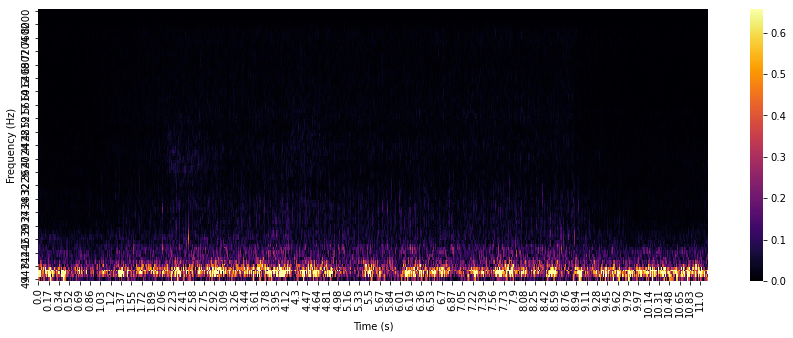

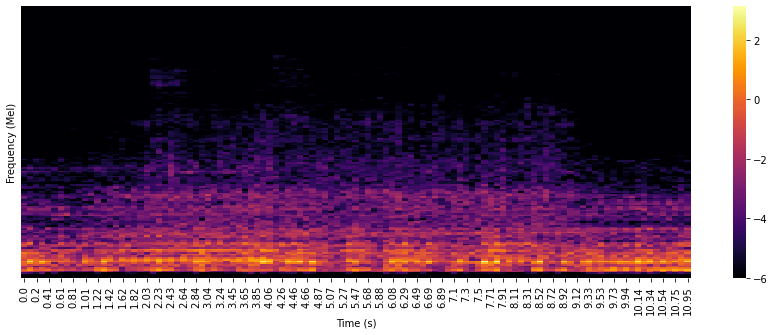

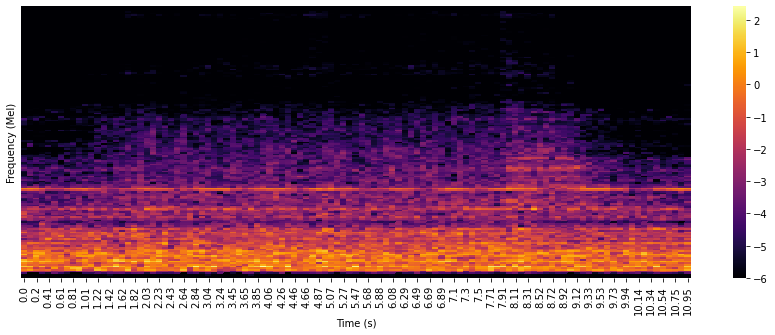

In [19]:
##Récupération des fréquences d'échantillonage
_,fe = lb.load('slider/train/normal_id_00_00000000.wav', sr=None)
_,fe_tc = lb.load('ToyCar/train/normal_id_01_00000000.wav', sr=None)

##Chargement d'un fichier normal
samples=sliders[50]
samples_tc=toycars[10]

##Chargement d'un fichier anormal
samples2=sliders_a[50] 
samples2_tc=toycars_a[10]

"""FONCTIONS"""
##Fonction d'affichage du signal audio
def plot_audio(audio_data, fe):
    t = np.arange(len(audio_data))/fe 
    plt.plot(t, audio_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

#Fonctions d'affichage du Spectrogramme "classique"
def spectrogram(audio, fe, dt):
    return np.abs(lb.stft(audio,n_fft = int(dt*fe),hop_length = int(dt*fe/2)))

def plot_spectrogram(audio, fe, dt, hop_length):
    im = np.abs(lb.stft(audio,n_fft = int(dt*fe),hop_length=hop_length))
    sns.heatmap(np.rot90(im.T), cmap='inferno', vmin=0, vmax=np.max(im)/3)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    loc, labels = plt.yticks()
    l = np.array(loc[::-1]*fe/2/loc.max(), dtype=int)
    plt.yticks(loc, l)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

#Fontions d'affichage en echelle MEL et dB pour l'amplitude
def logMelSpectrogram(audio, params, fe):
    stfts = lb.stft(audio,n_fft = int(params['n_fft']),hop_length = int(params["frame_step"]),center = False).T
    power_spectrograms = np.real(stfts * np.conj(stfts))
    linear_to_mel_weight_matrix = lb.filters.mel(sr=fe,n_fft=int(params['n_fft']) + 1,n_mels=params['num_mel_bins'],
                                fmin=params['lower_edge_hertz'],fmax=params['upper_edge_hertz']).T
    mel_spectrograms = np.tensordot(power_spectrograms,linear_to_mel_weight_matrix, 1)
    return (np.log(mel_spectrograms + 1e-8).astype(np.float16))


def plot_logMelSpectrogram(audio, params, fe):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, params, fe)), cmap='inferno', vmin = -6)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")

"""FIGURES"""
params = {'n_fft': 160*16,'frame_step': 1600,'lower_edge_hertz': 0,'upper_edge_hertz': 8000,'num_mel_bins': 160}
dt=0.01
hop_length = int(dt*fe/2)

#Tracé signal audio
plt.figure(figsize=(12,5))
#plot_audio(samples, fe)
plot_audio(samples_tc, fe_tc)

#Tracé spectrogramme "classique"
plt.figure(figsize=(15,5))
#plot_spectrogram(samples, fe,dt,hop_length)
plot_spectrogram(samples_tc, fe_tc,dt,hop_length)

#Tracé spectrogramme en échelle MEL et dB        
plt.figure(figsize=(15,5))
#plot_logMelSpectrogram(samples, params, fe)
plot_logMelSpectrogram(samples_tc, params, fe_tc)

plt.figure(figsize=(15,5))
#plot_logMelSpectrogram(samples2, params, fe)
plot_logMelSpectrogram(samples2_tc, params, fe_tc)

#Possibilité d'écouter le son pour mieux comprendre le tracé
#Audio(samples, rate=fe)

Text(87.0, 0.5, 'Frequency (Mel)')

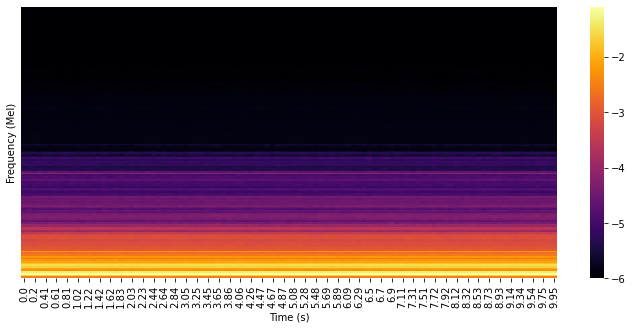

In [21]:
#Moyenne des spectrogrammes
LMS=logMelSpectrogram(sliders[0], params, fe)
for i in np.arange(1,len(sliders)):
    LMS+=logMelSpectrogram(sliders[i], params, fe)

LMS=LMS/len(sliders)

#Tracé
plt.figure(figsize=(12,5))
sns.heatmap(np.rot90(LMS), cmap='inferno', vmin = -6)
loc, labels = plt.xticks()
l = np.round((loc-loc.min())*len(sliders[0])/fe/loc.max(), 2)
plt.xticks(loc, l)
plt.yticks([])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")

(-100.0, 7500.0)

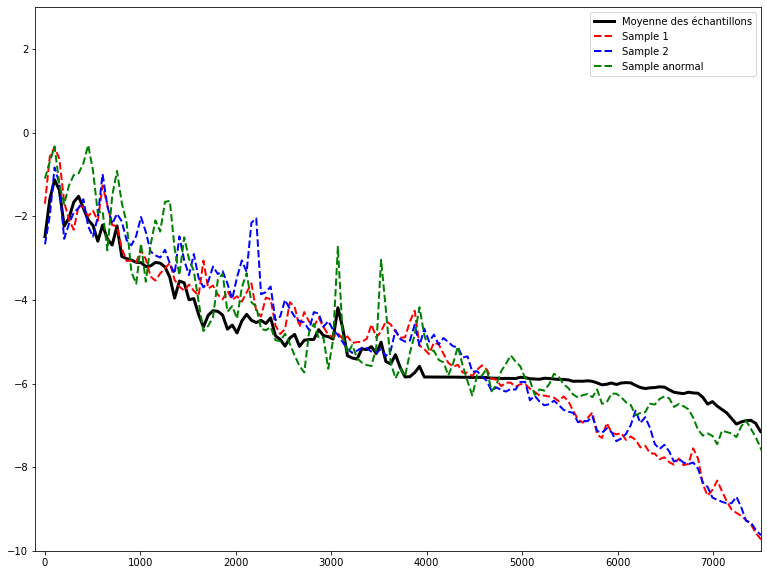

In [23]:
#Moyenne sur les fréquences
freq_dist=np.zeros(np.shape(LMS)[1])
for i in np.arange(0,np.shape(LMS)[0]):
    freq_dist+=LMS[i,:]
    
freq_dist/=np.shape(LMS)[0]

LMS1=logMelSpectrogram(sliders[1], params, fe)
freq_dist1=np.zeros(np.shape(LMS1)[1])
for i in np.arange(0,np.shape(LMS1)[0]):
    freq_dist1+=LMS1[i,:]
    
freq_dist1/=np.shape(LMS1)[0]

LMS2=logMelSpectrogram(sliders[80], params, fe)
freq_dist2=np.zeros(np.shape(LMS2)[1])
for i in np.arange(0,np.shape(LMS2)[0]):
    freq_dist2+=LMS2[i,:]
    
freq_dist2/=np.shape(LMS2)[0]

LMSA=logMelSpectrogram(sliders_a[10], params, fe)
freq_distA=np.zeros(np.shape(LMSA)[1])
for i in np.arange(0,np.shape(LMSA)[0]):
    freq_distA+=LMSA[i,:]
    
freq_distA/=np.shape(LMSA)[0]

plt.figure(figsize=(13,10))
plt.plot(np.linspace(1,8000,(np.shape(LMS)[1])),freq_dist,'black',linewidth=3,label='Moyenne des échantillons')
plt.plot(np.linspace(1,8000,(np.shape(LMS1)[1])),freq_dist1,'r--',linewidth=2,label='Sample 1')
plt.plot(np.linspace(1,8000,(np.shape(LMS2)[1])),freq_dist2,'b--',linewidth=2,label='Sample 2')
plt.plot(np.linspace(1,8000,(np.shape(LMSA)[1])),freq_distA,'g--',linewidth=2,label='Sample anormal')
plt.legend()
plt.ylim(-10,3)
plt.xlim(-100,7500)

Text(87.0, 0.5, 'Frequency (Mel)')

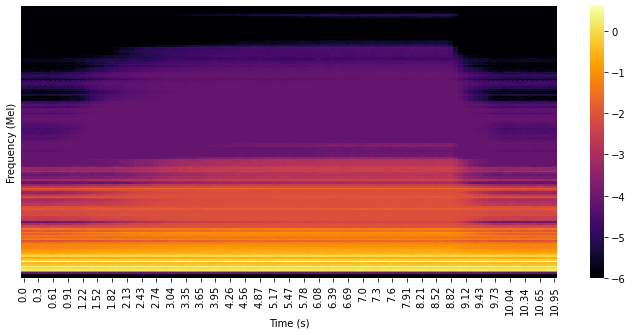

In [24]:
#Moyenne des spectrogrammes
LMStc=logMelSpectrogram(toycars[0], params, fe)
for i in np.arange(1,len(toycars)):
    LMStc+=logMelSpectrogram(toycars[i], params, fe)

LMStc=LMStc/len(toycars)

#Tracé
plt.figure(figsize=(12,5))
sns.heatmap(np.rot90(LMStc), cmap='inferno', vmin = -6)
loc, labels = plt.xticks()
l = np.round((loc-loc.min())*len(toycars[0])/fe/loc.max(), 2)
plt.xticks(loc, l)
plt.yticks([])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")

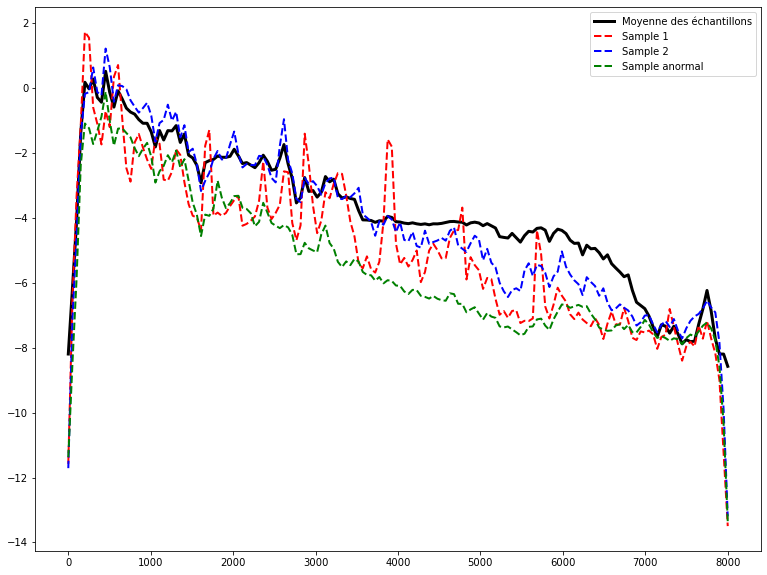

In [34]:
#Moyenne sur les fréquences
freq_dist_tc=np.zeros(np.shape(LMStc)[1])
for i in np.arange(0,np.shape(LMStc)[0]):
    freq_dist_tc+=LMStc[i,:]
    
freq_dist_tc/=np.shape(LMStc)[0]

LMStc1=logMelSpectrogram(toycars[1], params, fe)
freq_dist1_tc=np.zeros(np.shape(LMStc1)[1])
for i in np.arange(0,np.shape(LMStc1)[0]):
    freq_dist1_tc+=LMStc1[i,:]
    
freq_dist1_tc/=np.shape(LMStc1)[0]

LMStc2=logMelSpectrogram(toycars[80], params, fe)
freq_dist2_tc=np.zeros(np.shape(LMStc2)[1])
for i in np.arange(0,np.shape(LMStc2)[0]):
    freq_dist2_tc+=LMStc2[i,:]
    
freq_dist2_tc/=np.shape(LMStc2)[0]

LMSAtc=logMelSpectrogram(toycars_a[200], params, fe)
freq_distAtc=np.zeros(np.shape(LMSAtc)[1])
for i in np.arange(0,np.shape(LMSAtc)[0]):
    freq_distAtc+=LMSAtc[i,:]
    
freq_distAtc/=np.shape(LMSAtc)[0]

plt.figure(figsize=(13,10))
plt.plot(np.linspace(1,8000,(np.shape(LMStc)[1])),freq_dist_tc,'black',linewidth=3,label='Moyenne des échantillons')
plt.plot(np.linspace(1,8000,(np.shape(LMStc1)[1])),freq_dist1_tc,'r--',linewidth=2,label='Sample 1')
plt.plot(np.linspace(1,8000,(np.shape(LMStc2)[1])),freq_dist2_tc,'b--',linewidth=2,label='Sample 2')
plt.plot(np.linspace(1,8000,(np.shape(LMSAtc)[1])),freq_distAtc,'g--',linewidth=2,label='Sample anormal')
plt.legend()

(0.0, 7000.0)

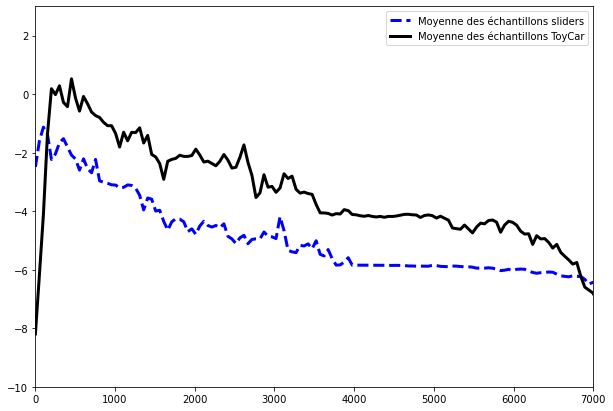

In [32]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(1,8000,(np.shape(LMS)[1])),freq_dist,'b--',linewidth=3,label='Moyenne des échantillons sliders')
plt.plot(np.linspace(1,8000,(np.shape(LMStc)[1])),freq_dist_tc,'black',linewidth=3,label='Moyenne des échantillons ToyCar')
plt.legend()
plt.ylim(-10,3)
plt.xlim(0,7000)

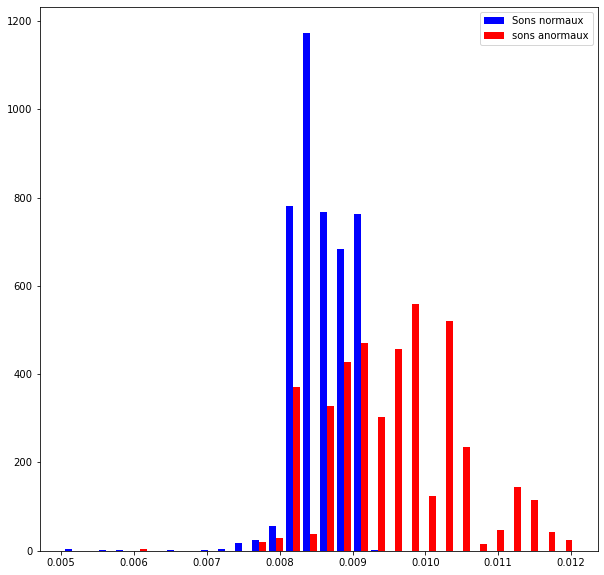

In [28]:
#Volume sonore
niveaux=[]
for i in np.arange(1,len(sliders)):
    niveaux.append(np.mean(((sliders[i])**2)**0.5))
    
niveaux_a=[]
for i in np.arange(1,len(sliders_a)):
    niveaux_a.append(np.mean(((sliders_a[i])**2)**0.5))


plt.figure(figsize=(10,10))
plt.hist([niveaux,niveaux_a],bins=30,rwidth=0.8,label=['Sons normaux','sons anormaux'],color=['blue','red'],density=True)
plt.xlabel=('Valeur efficace')
plt.ylabel=('Fréquences')
plt.title=('Histogramme valeurs efficaces - Slider')
plt.legend();


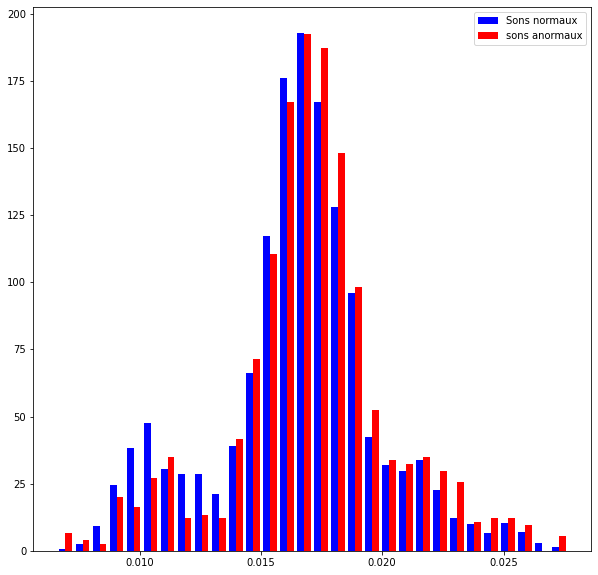

In [29]:
#Volume sonore
niveaux_tc=[]
for i in np.arange(1,len(toycars)):
    niveaux_tc.append(np.mean(((toycars[i])**2)**0.5))

niveaux_tc_a=[]
for i in np.arange(1,len(toycars_a)):
    niveaux_tc_a.append(np.mean(((toycars_a[i])**2)**0.5))

plt.figure(figsize=(10,10))
plt.hist([niveaux_tc,niveaux_tc_a],bins=30,rwidth=0.8,label=['Sons normaux','sons anormaux'],color=['blue','red'],density=True)
plt.xlabel=('Valeur efficace')
plt.ylabel=('Fréquences')
plt.title=('Histogramme valeurs efficaces - Toycar')
plt.legend();